In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from scipy import stats
import pylab as plt
import torch
import swyft
import numpy as np
import pylab as plt
import scipy.stats

ModuleNotFoundError: No module named 'torch'

In [ ]:
def resample_uniform(bounds):
    """This function samples from the bounded region, with typical-set stabilization."""
    N = len(bounds)
    ulo, uhi = bounds.T
    ulo = np.clip(ulo, 0., 1.)
    uhi = np.clip(uhi, 0., 1.)
    width = uhi-ulo
    u_BS = ulo + np.random.rand(N)*width  # bounded samples
    idx_BS = np.argsort(np.argsort(u_BS))
    u_free = np.random.rand(N)  # unbounded samples
    u_free_sorted = np.sort(u_free)  # sorted unbounded samples
    u = u_free_sorted[idx_BS]
    return u

def resample(dist, bounds):
    u_bounds = dist.cdf(bounds)
    u = resample_uniform(u_bounds)
    return dist.ppf(u)

def resample_norm(bounds):
    dist = scipy.stats.norm(0, 1)
    return resample(dist, bounds)

In [4]:
def rrfft(a):
    n = len(a)
    c = np.empty(n)
    b = np.fft.rfft(a, norm = 'ortho')
    if n%2 == 0:
        b_real, b_imag = np.real(b), np.imag(b)[1:-1]
        b_real[1:-1] *= 2**0.5
        b_imag *= 2**0.5
    else:
        b_real, b_imag = np.real(b), np.imag(b)[1:]
        b_real[1:] *= 2**0.5
        b_imag *= 2**0.5
    c[0], c[1::2], c[2::2] = b_real[0], b_real[1:], b_imag
    return c

def rirfft(a):
    n = len(a)
    if n%2 == 0:
        b = np.zeros(int(n/2)+1, dtype = np.complex128)
        b[0] += a[0]
        b[1:] += a[1::2]/2**0.5
        b[-1] *= 2**0.5
        b[1:-1] += a[2::2]*1j/2**0.5
    else:
        b = np.zeros(int(n/2)+1, dtype = np.complex128)
        b[0] += a[0]
        b[1:] += a[1::2]/2**0.5
        b[1:] += a[2::2]*1j/2**0.5
    c = np.fft.irfft(b, n, norm = 'ortho')
    return c

In [5]:
def rrfft_torch(a):
    n = a.shape[-1]
    c = torch.empty_like(a)
    b = torch.fft.rfft(a, norm = 'ortho')
    if n%2 == 0:
        b_real, b_imag = torch.real(b), torch.imag(b)[..., 1:-1]
        b_real[..., 1:-1] *= 2**0.5
        b_imag *= 2**0.5
    else:
        b_real, b_imag = torch.real(b), torch.imag(b)[1:]
        b_real[1:] *= 2**0.5
        b_imag *= 2**0.5
    c[..., 0], c[..., 1::2], c[..., 2::2] = b_real[..., 0], b_real[..., 1:], b_imag
    return c

def rirfft_torch(a):
    n = a.shape[-1]
    if n%2 == 0:
        b = torch.zeros(*a.shape[:-1], int(n/2)+1)*1j
        b[..., 0] += a[..., 0]
        b[..., 1:] += a[..., 1::2]/2**0.5
        b[..., -1] *= 2**0.5
        b[..., 1:-1] += a[..., 2::2]*1j/2**0.5
    else:
        b = torch.zeros(*a.shape[:-1], int(n/2)+1)*1j
        b[..., 0] += a[..., 0]
        b[..., 1:] += a[..., 1::2]/2**0.5
        b[..., 1:] += a[..., 2::2]*1j/2**0.5
    c = torch.fft.irfft(b, n, norm = 'ortho')
    return c

## Simulator definition

In [6]:
class Simulator(swyft.Simulator):
    def __init__(self, bounds_n = None, bounds_fNL = None, Nbins = 100, sigma = .3):
        super().__init__()
        self.transform_samples = swyft.to_numpy32
        self.Nbins = Nbins
        self.sigma = sigma
        self.x = np.linspace(-1, 1, Nbins)
        
        self.z_sampler = swyft.RectBoundSampler(
            [stats.uniform(0, 2),
            ],
            bounds = bounds_fNL
        )

        if bounds_n is None:
            bounds_n = np.ones((Nbins, 2))*self.sigma*5
            bounds_n[:,0] *= -1
        self.bounds_n = bounds_n

    def n_sampler(self):
        n = resample_norm(self.bounds_n/self.sigma)*self.sigma
        return n
    
    def add_fNL(self, fNL, dG):
        d = dG + fNL[0]*(dG**2 - (dG**2).mean())
        d = d/d.var()**0.5
        d = rirfft(d)
        d[d>2] += 1.0
        d = rrfft(d)
        return d
        
    def build(self, graph):
        n = graph.node("n", lambda: self.n_sampler())
        fNL = graph.node("fNL", self.z_sampler)
        dG = graph.node("dG", lambda n: 0*n + rirfft(n), n)
        d = graph.node("d", self.add_fNL, fNL, dG)

### Target observation and open bounds

In [7]:
NBINS = 4000
obs = Simulator(Nbins = NBINS).sample(conditions = {'fNL': np.array([1.0])})
bounds_n = None
bounds_fNL = None
obs['fNL']

array([1.], dtype=float32)

## *** Define round simulator

In [36]:
sim = Simulator(Nbins = NBINS, bounds_n = bounds_n, bounds_fNL = bounds_fNL)

### Generate training data

In [37]:
samples = sim.sample(3_000)
dm = swyft.SwyftDataModule(samples, fractions = [0.8, 0.1, 0.1], num_workers = 0, batch_size = 64)

  0%|          | 0/3000 [00:00<?, ?it/s]

(-0.02, 0.02)

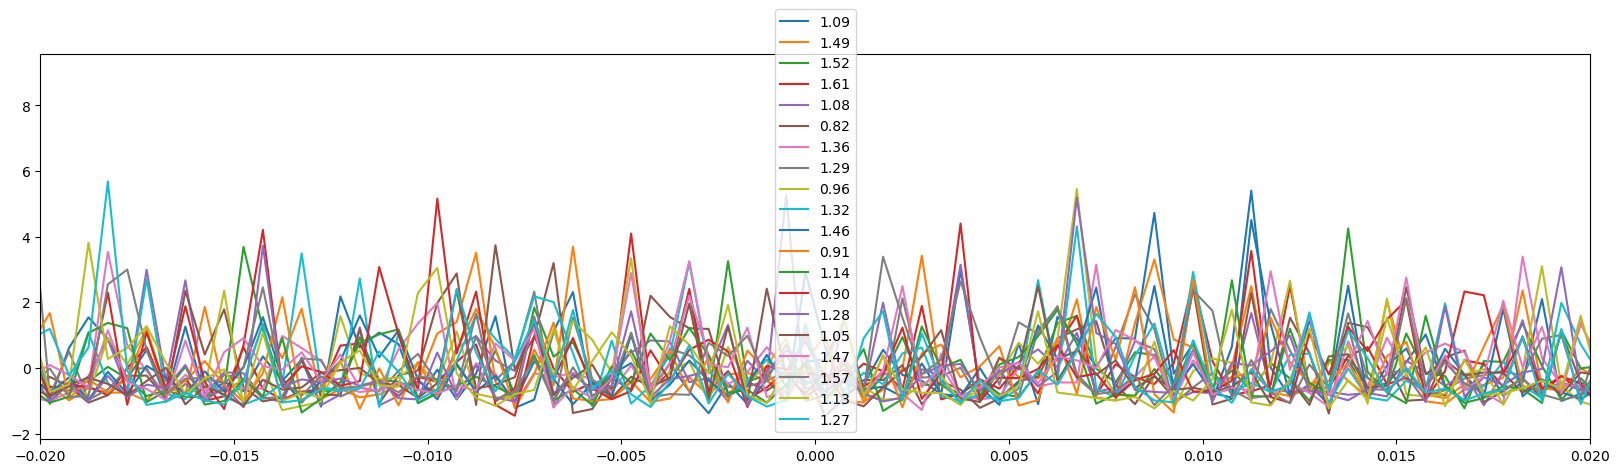

In [38]:
plt.figure(figsize = (20, 5))
for i in range(20):
    plt.plot(sim.x, samples[i]['d'], label = '%.2f'%samples[i]['fNL'][0])
plt.legend()
#    plt.plot(sim.x, samples[i]['m'], 'r:', zorder = 100)
#plt.plot(sim.x, obs['d'], 'y', lw = 2, zorder = 99)
#plt.plot(sim.x, obs['m'], 'g', lw = 5, zorder = 200)
plt.xlim([-0.02, 0.02])

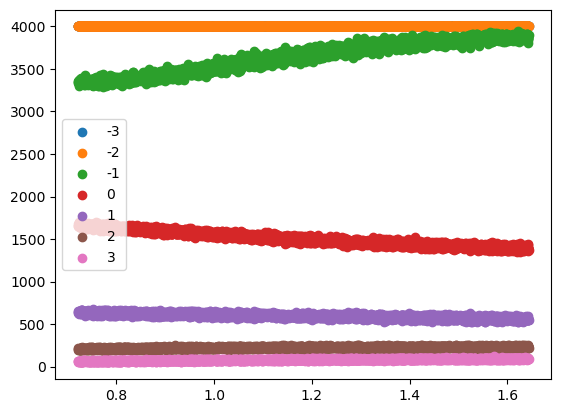

In [39]:
for c in [-3, -2, -1, 0, 1, 2, 3]:
    plt.scatter(samples['fNL'][:,0], (samples['d']>c).sum(axis=1), label = c)
plt.legend()

## Define inference network

In [40]:
class Network(swyft.SwyftModule):
    def __init__(self):
        super().__init__()
        self.lin_1 = torch.nn.Linear(NBINS, 32)
        self.logratios1 = swyft.LogRatioEstimator_1dim(num_features = 7, num_params = 1, varnames = 'fNL',
                                                       dropout = 0.2, hidden_features = 128)
        self.logratios2 = swyft.LogRatioEstimator_1dim_Gaussian(num_params = NBINS, varnames = 'n')
        self.optimizer_init = swyft.AdamOptimizerInit(lr = 1e-3, lrs_factor = 0.3, lrs_patience = 1)
        
        self.sl = swyft.networks.OnlineStandardizingLayer(shape = (4000,))
        self.sl2 = swyft.networks.OnlineStandardizingLayer(shape = (7,))

    def forward(self, A, B):
        # Estimate signal parameters
        D = A['d']
        
        n = A['n']
        idx = torch.randperm(n.shape[0])
        n = n[idx].view(n.size())
        
 #       D = self.sl(D)
#        f = self.lin_1(D)  # data summaries
        f = [(D>c).sum(axis=-1)*1. for c in [-3, -2, -1, 0, 1, 2, 3]]
        f = torch.stack(f).T
        f = self.sl2(f)
#        print(f.shape)
#        qwerty
        logratios1 = self.logratios1(f, B['fNL'])
        
        # Estimate noise
        df = rrfft_torch(A['d'])
#        df = A['d']
        logratios2 = self.logratios2(df, B['n'])
 
        return logratios1, logratios2

network = Network()

In [41]:
trainer = swyft.SwyftTrainer(accelerator = 'cpu', devices=1, max_epochs = 5, precision = 32)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [42]:
trainer.fit(network, dm)


  | Name       | Type                            | Params
---------------------------------------------------------------
0 | lin_1      | Linear                          | 128 K 
1 | logratios1 | LogRatioEstimator_1dim          | 68.4 K
2 | logratios2 | LogRatioEstimator_1dim_Gaussian | 0     
3 | sl         | OnlineStandardizingLayer        | 0     
4 | sl2        | OnlineStandardizingLayer        | 0     
---------------------------------------------------------------
196 K     Trainable params
0         Non-trainable params
196 K     Total params
0.786     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


In [43]:
prior_samples = sim.sample(1_000, targets = ['fNL', 'n'])

  0%|          | 0/1000 [00:00<?, ?it/s]

In [44]:
predictions = trainer.infer(network, obs, prior_samples)

Predicting: 38it [00:00, ?it/s]

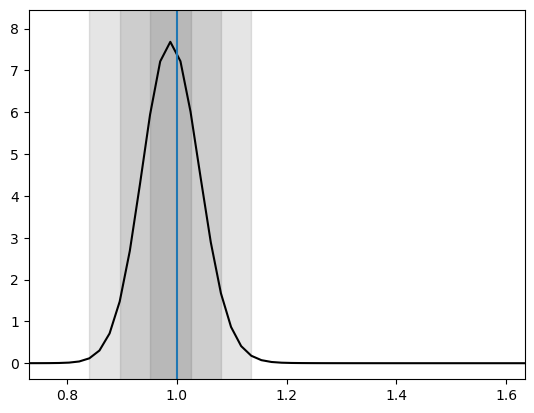

In [45]:
swyft.plot_1d(predictions, "fNL[0]", bins=50, smooth = 2)
plt.axvline(obs['fNL'][0])

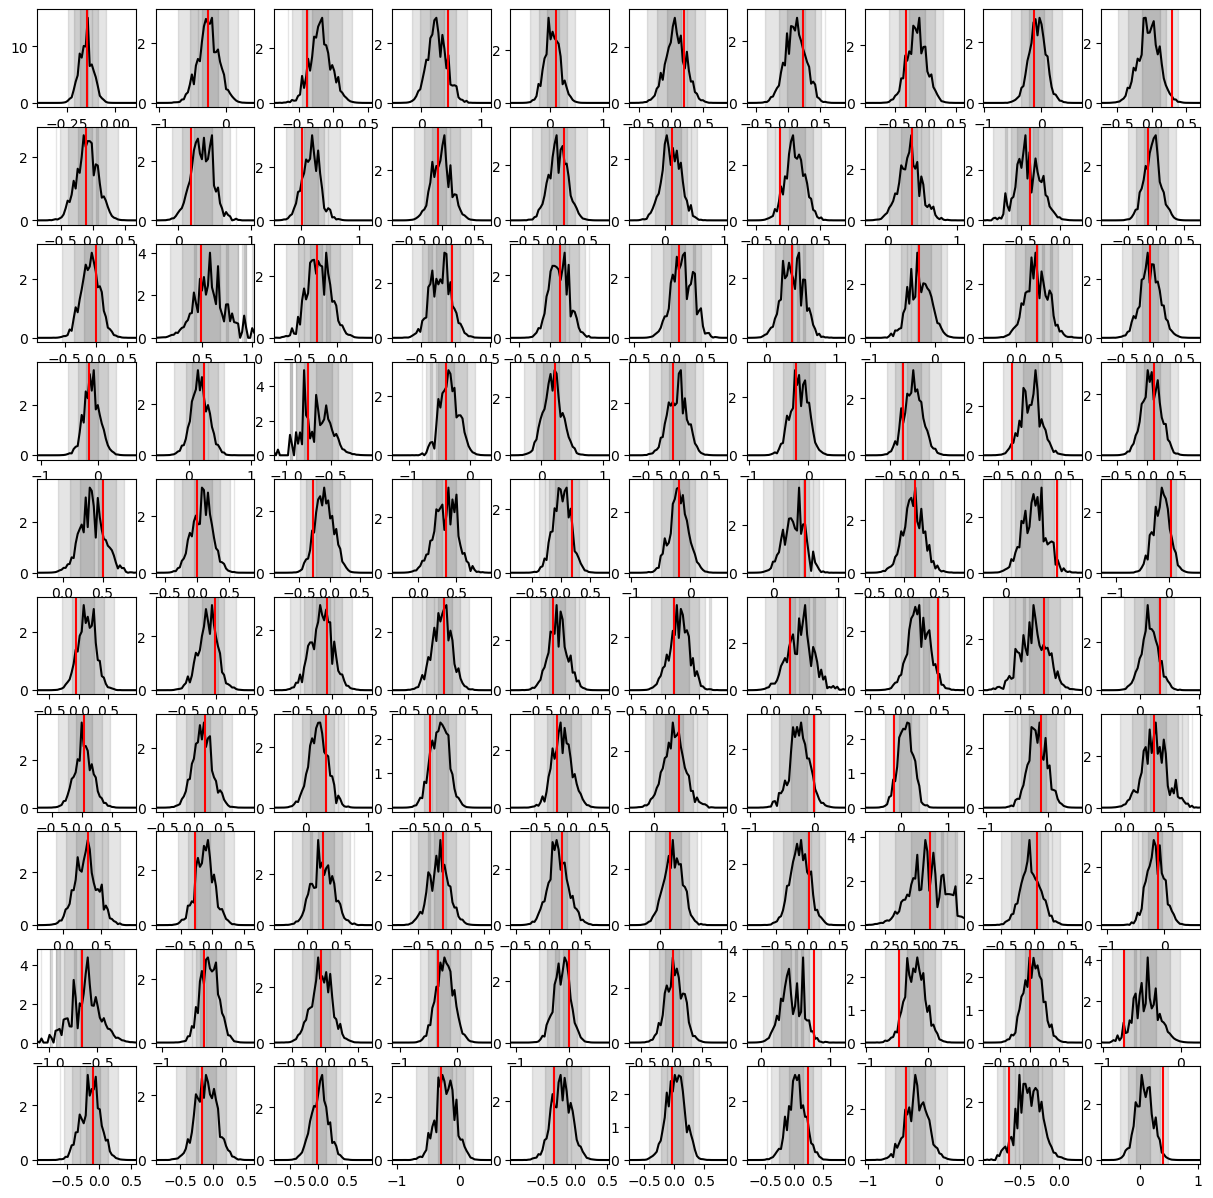

In [33]:
_, axs = plt.subplots(10, 10, figsize = (15, 15))
for i in range(10):
    for j in range(10):
        k = i + j*10
        swyft.plot_1d(predictions, "n[%i]"%k, ax = axs[i][j], bins=50)
        axs[i][j].axvline(obs['n'][k], color='r')

In [34]:
bounds_n = swyft.collect_rect_bounds(predictions[1], 'n', (NBINS,), threshold = 1e-6)
bounds_fNL = swyft.collect_rect_bounds(predictions[0], 'fNL', (1,), threshold = 1e-6)
bounds_fNL

tensor([[0.7211, 1.6434]])

In [35]:
bounds_n

tensor([[-0.3379,  0.0362],
        [-0.8793,  0.6908],
        [-0.9536,  0.6671],
        ...,
        [-0.3690,  1.0292],
        [-1.0287,  0.6600],
        [-0.7279,  0.8244]])